<a href="https://colab.research.google.com/github/DiyaSNS/WIDS-2025---Ask-the-Image-Explainable-Al-for-Visual-Q-A/blob/main/Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
"""
Week 3 Assignment: Explainable AI (XAI) for Vision Models
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image
import os
from tqdm import tqdm

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}\n")

# Create output directory
os.makedirs('xai_outputs', exist_ok=True)


Using device: cuda



PROBLEM 1: Vision Model Setup

📥 Loading CIFAR-10 dataset...


100%|██████████| 170M/170M [00:03<00:00, 42.8MB/s]


✓ Dataset loaded
Training samples: 50000
Test samples: 10000
Classes: ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

🤖 Loading pretrained ResNet-50...
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 178MB/s]


 Model loaded: ResNet-50
Total parameters: 23,528,522
Trainable parameters: 23,528,522

Model Architecture Summary:
------------------------------------------------------------
conv1                -> Conv2d                        
bn1                  -> BatchNorm2d                   
relu                 -> ReLU                          
maxpool              -> MaxPool2d                     
layer1               -> Sequential                    
layer2               -> Sequential                    
layer3               -> Sequential                    
layer4               -> Sequential                    
avgpool              -> AdaptiveAvgPool2d             
fc                   -> Linear                        
------------------------------------------------------------

 Training model (fine-tuning final layer)...


Epoch 3/3: 100%|██████████| 391/391 [02:48<00:00,  2.32it/s, loss=0.661, acc=78]

Training complete

 Evaluating on test set...


Test Accuracy: 78.38%

Sample Predictions:
------------------------------------------------------------


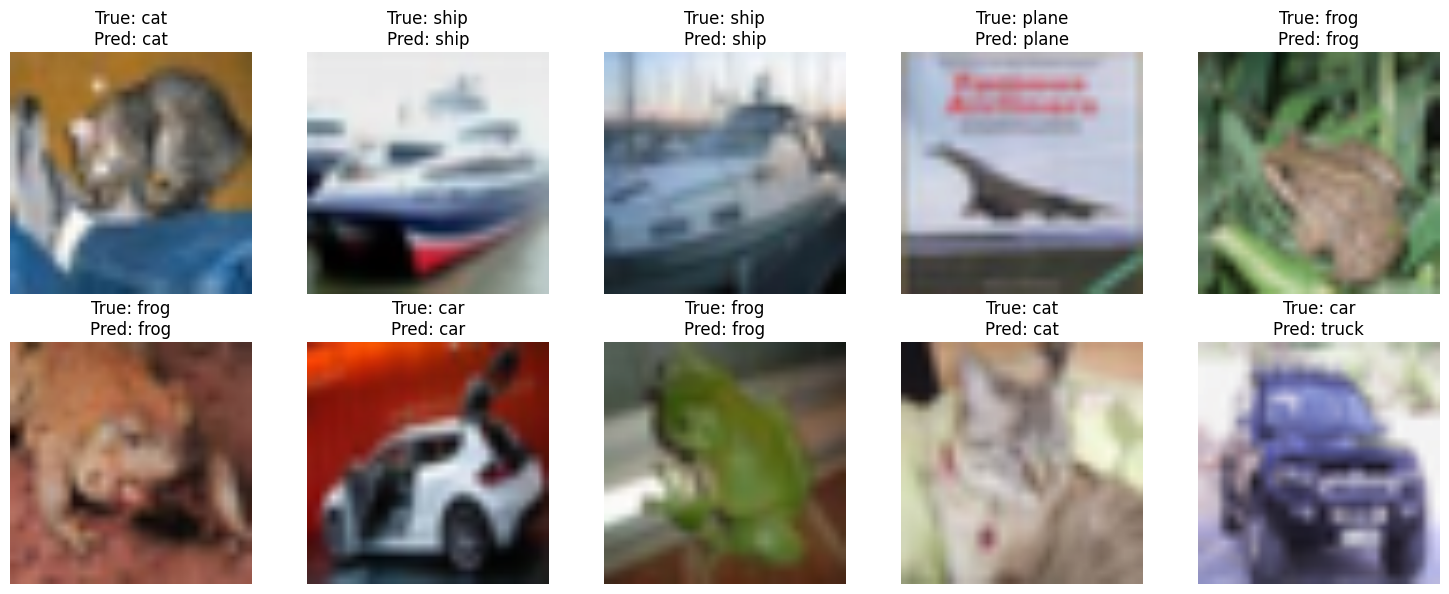

 Sample predictions saved to xai_outputs/problem1_predictions.png

PROBLEM 2: Visualizing Learned Filters

 Visualizing first layer filters (conv1)...


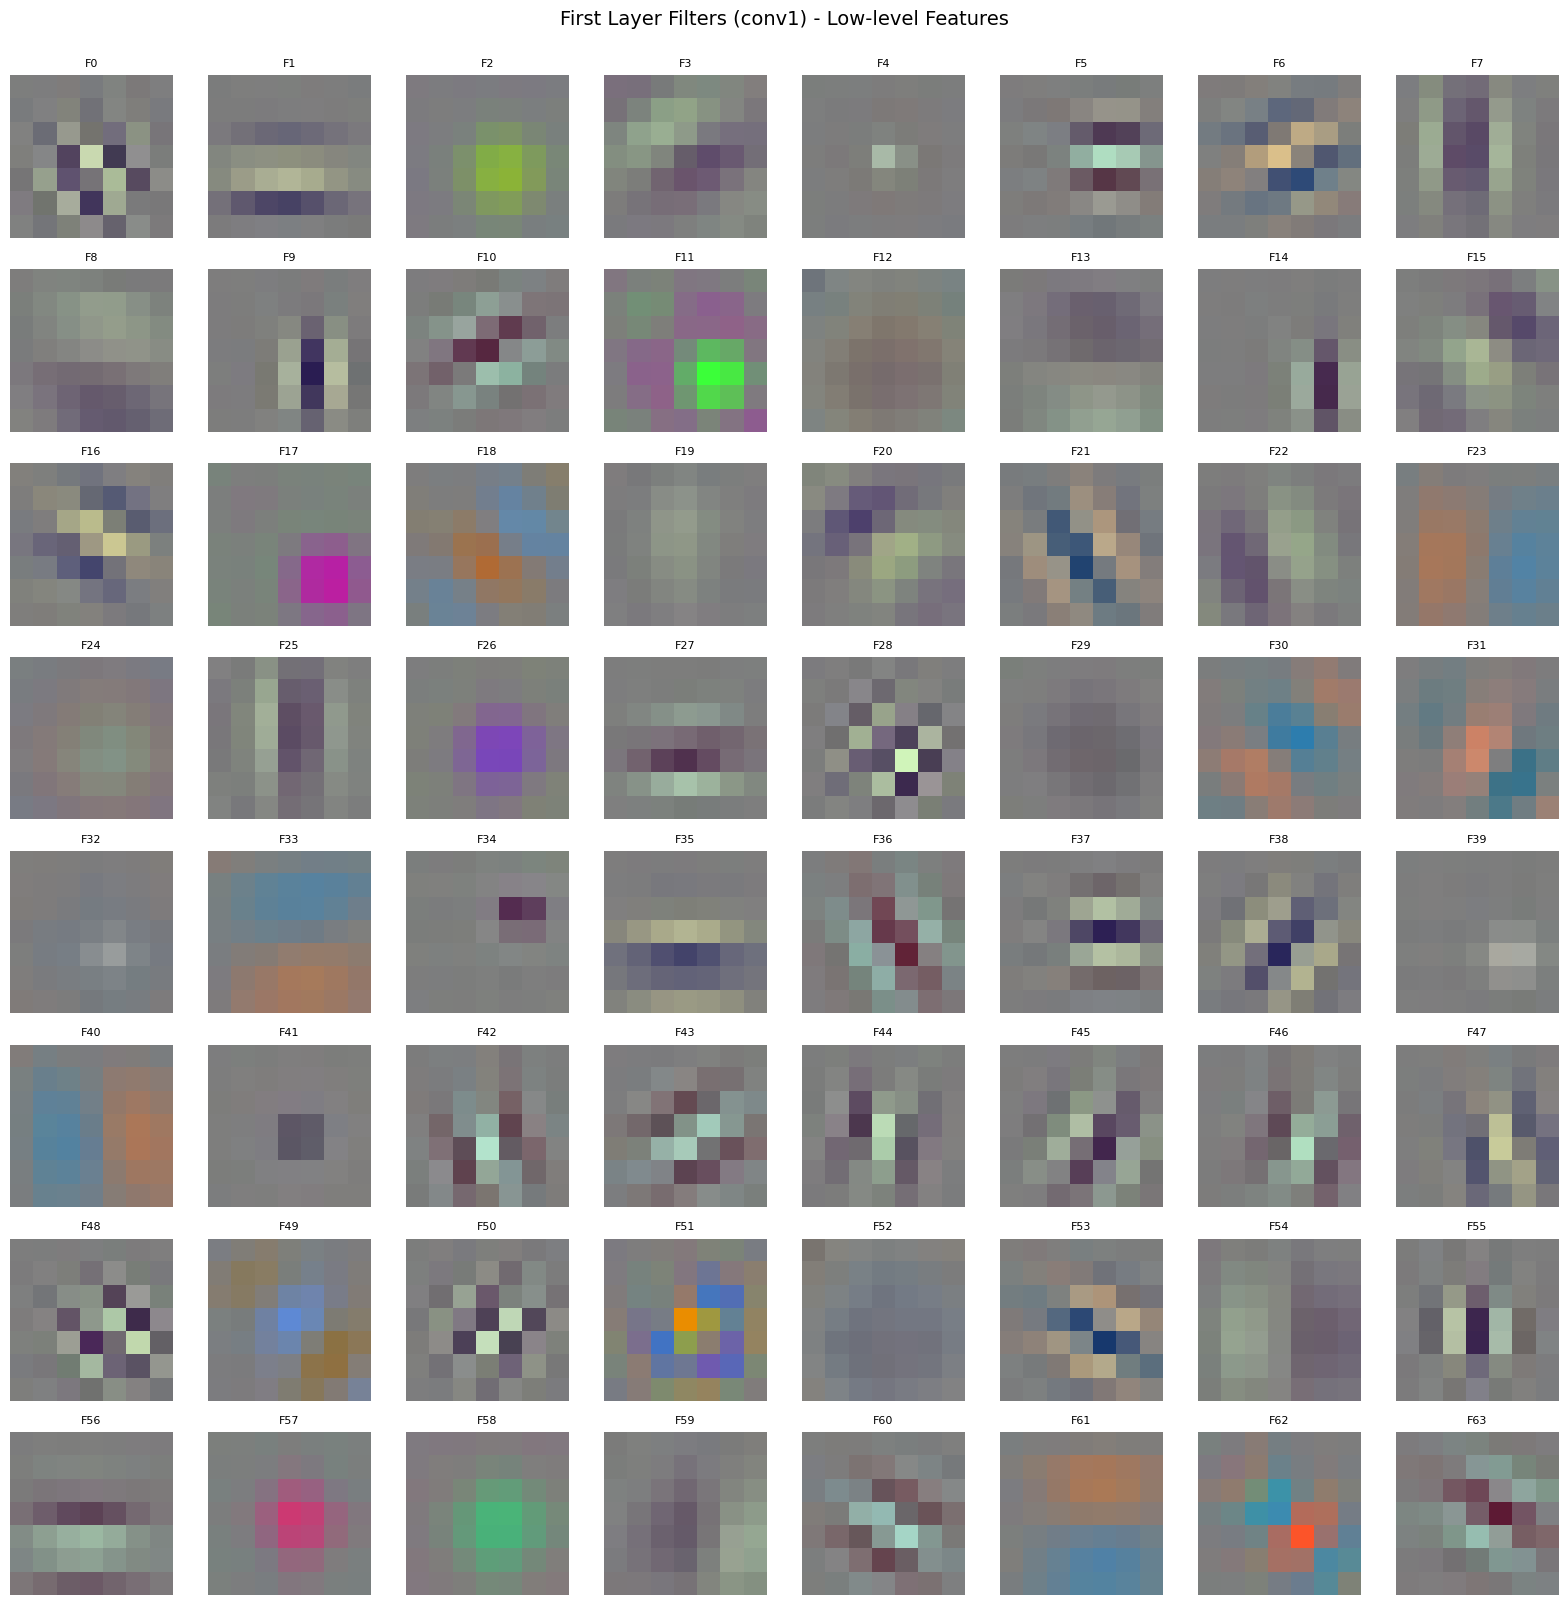

 First layer filters saved

 Visualizing deeper layer filters (layer2.0.conv1)...


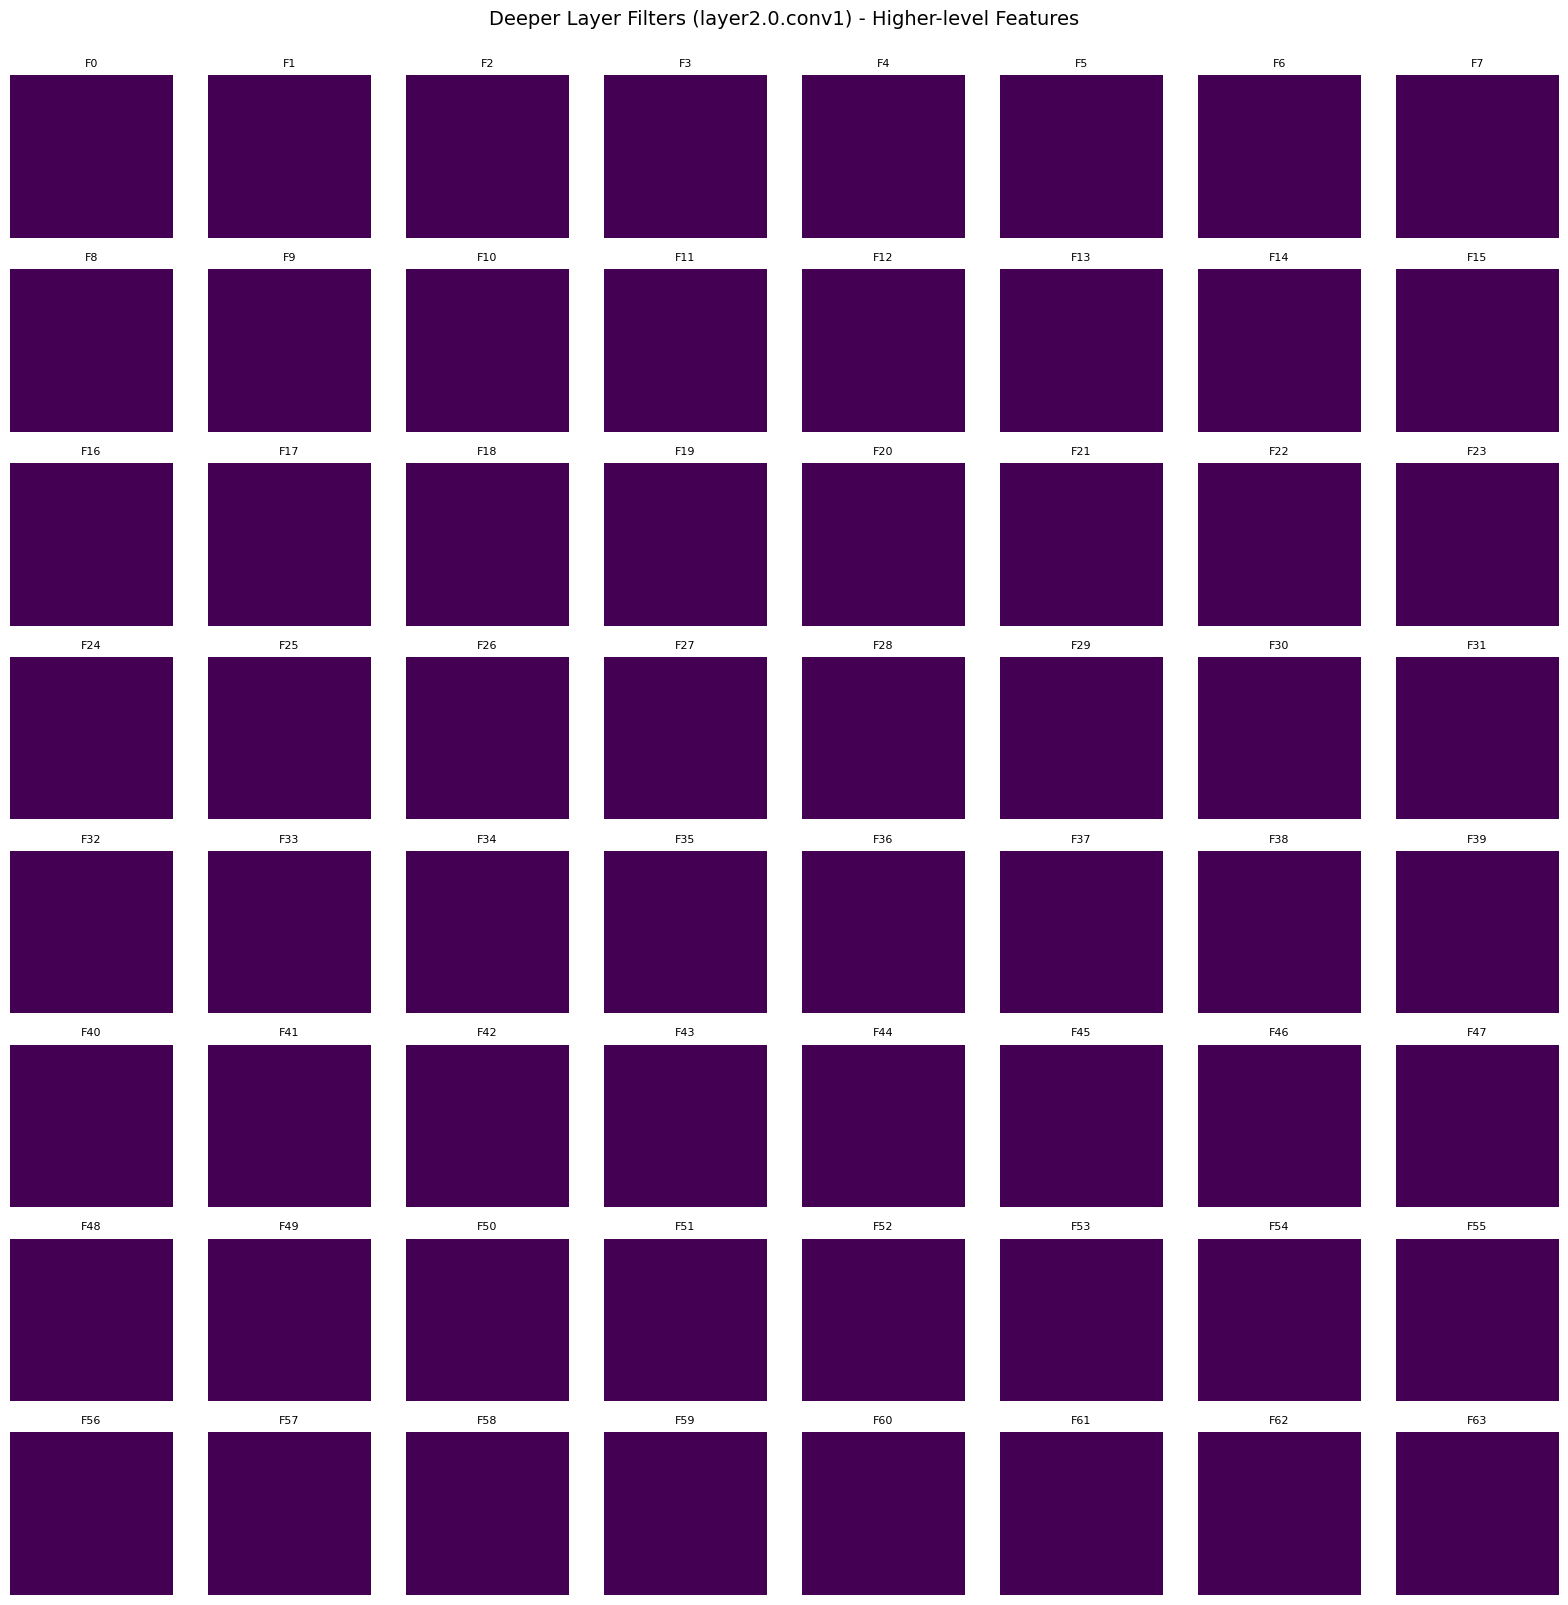

 Deeper layer filters saved

Analysis:
------------------------------------------------------------
First Layer Filters:
  • Capture low-level patterns: edges, corners, color gradients
  • Simple, interpretable patterns (horizontal/vertical edges)
  • Act as basic feature detectors

Deeper Layer Filters:
  • More complex, abstract patterns
  • Harder to interpret visually
  • Detect combinations of low-level features
  • Represent higher-level semantic concepts
------------------------------------------------------------

PROBLEM 3: Feature Map Visualization

 Selecting test image for feature map visualization...
Extracting feature maps from layer3.0.conv1...
Feature map shape: torch.Size([1, 256, 28, 28])


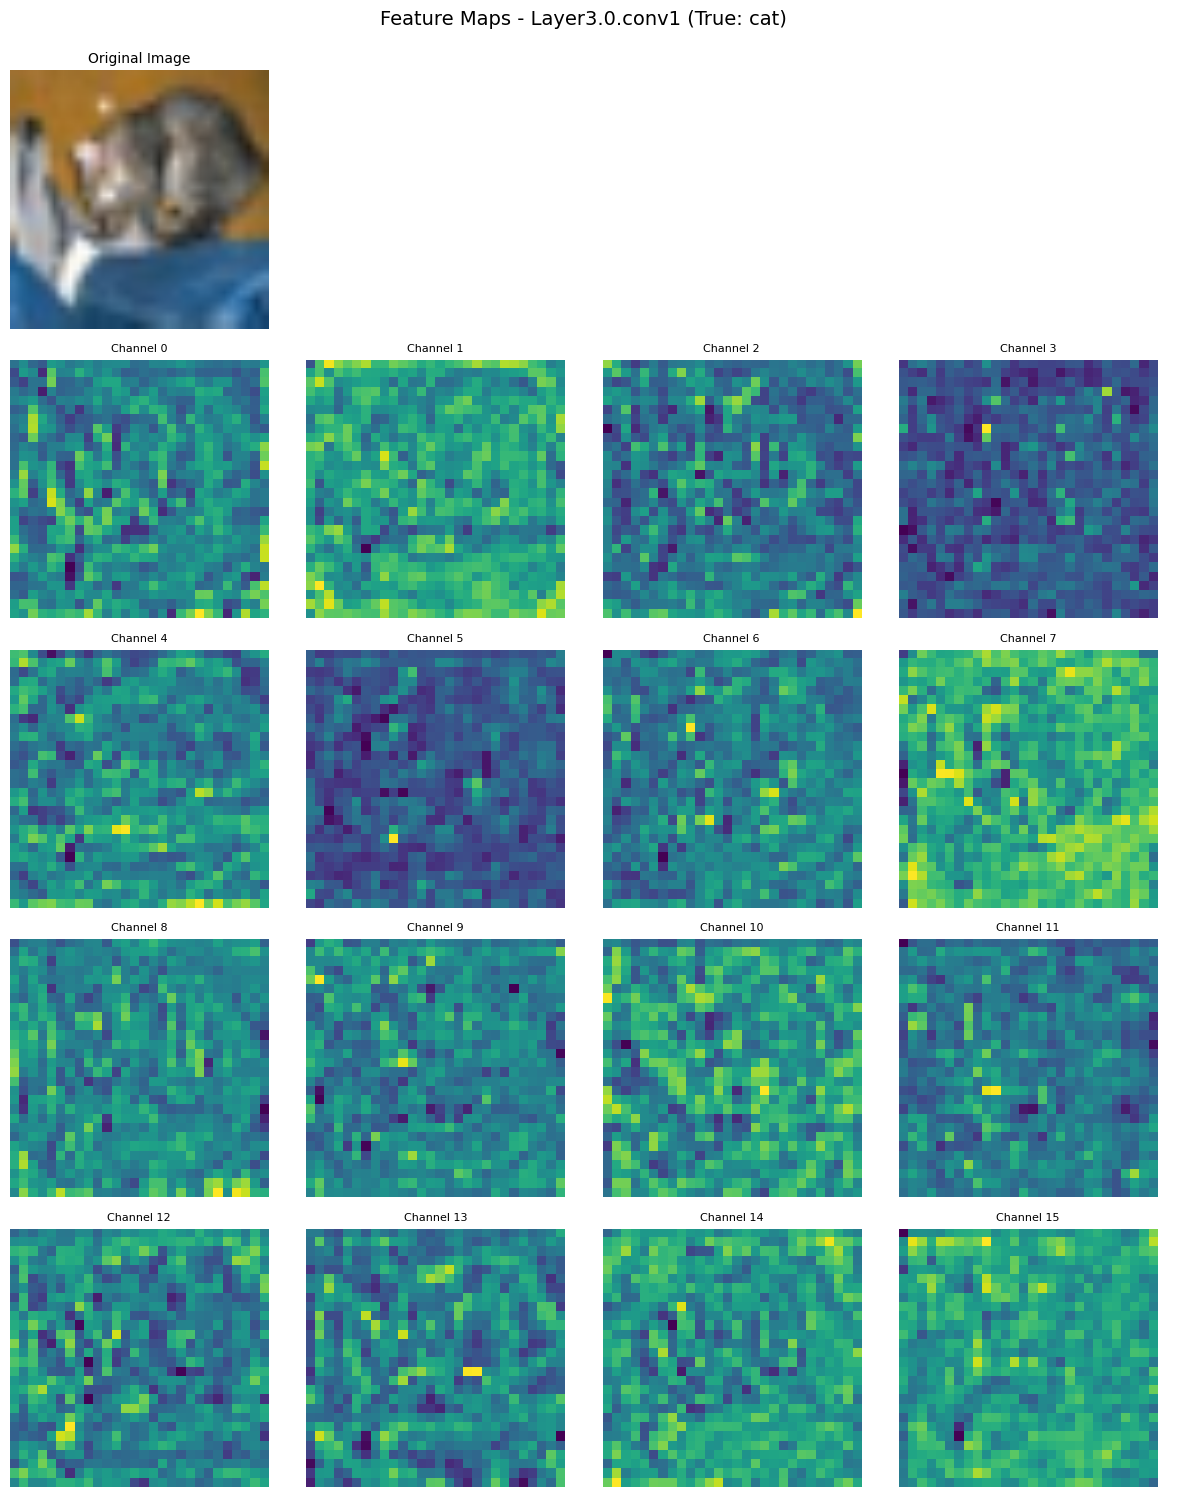

✓ Feature maps saved

Discussion:
------------------------------------------------------------
Feature Map Observations:
  • Different channels activate for different image regions
  • Some channels focus on edges and boundaries
  • Others respond to textures and patterns
  • Activations are sparse - most channels show selective responses
  • Higher activation (brighter) = stronger feature presence
------------------------------------------------------------

PROBLEM 4: Grad-CAM Implementation

 Initializing Grad-CAM (target layer: layer4)...
Finding correctly classified images...


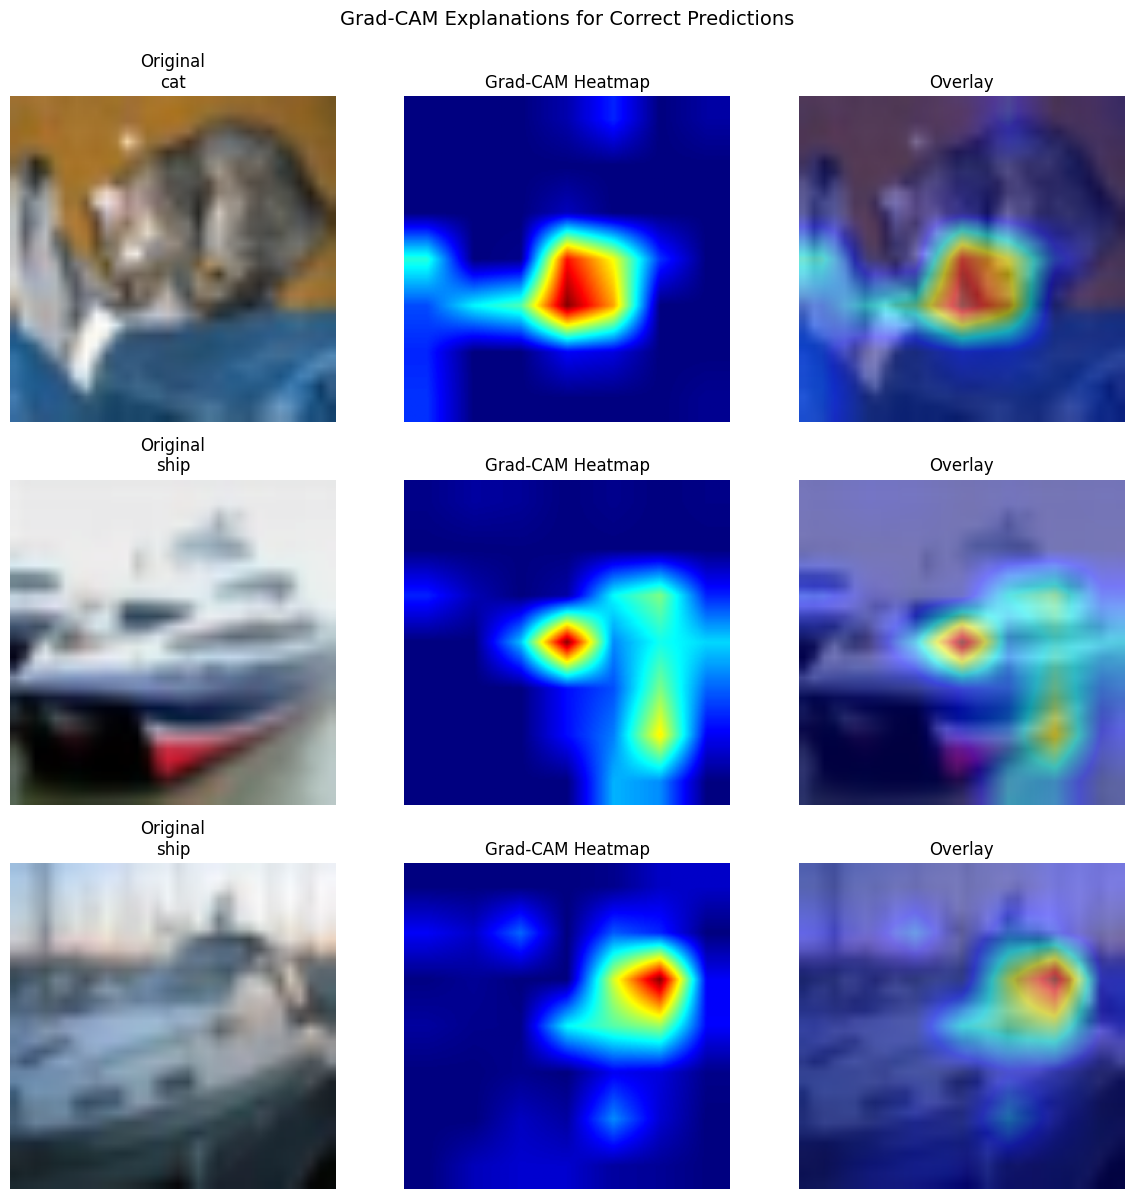

✓ Grad-CAM visualizations saved

Interpretation:
------------------------------------------------------------
Grad-CAM Analysis (Correctly Classified):
  • Heatmaps highlight discriminative regions
  • Model focuses on object-specific features
  • Bright regions = high importance for prediction
  • Alignswith human intuition (focuses on main object)
------------------------------------------------------------

PROBLEM 5: Failure Case Analysis

 Finding misclassified images...


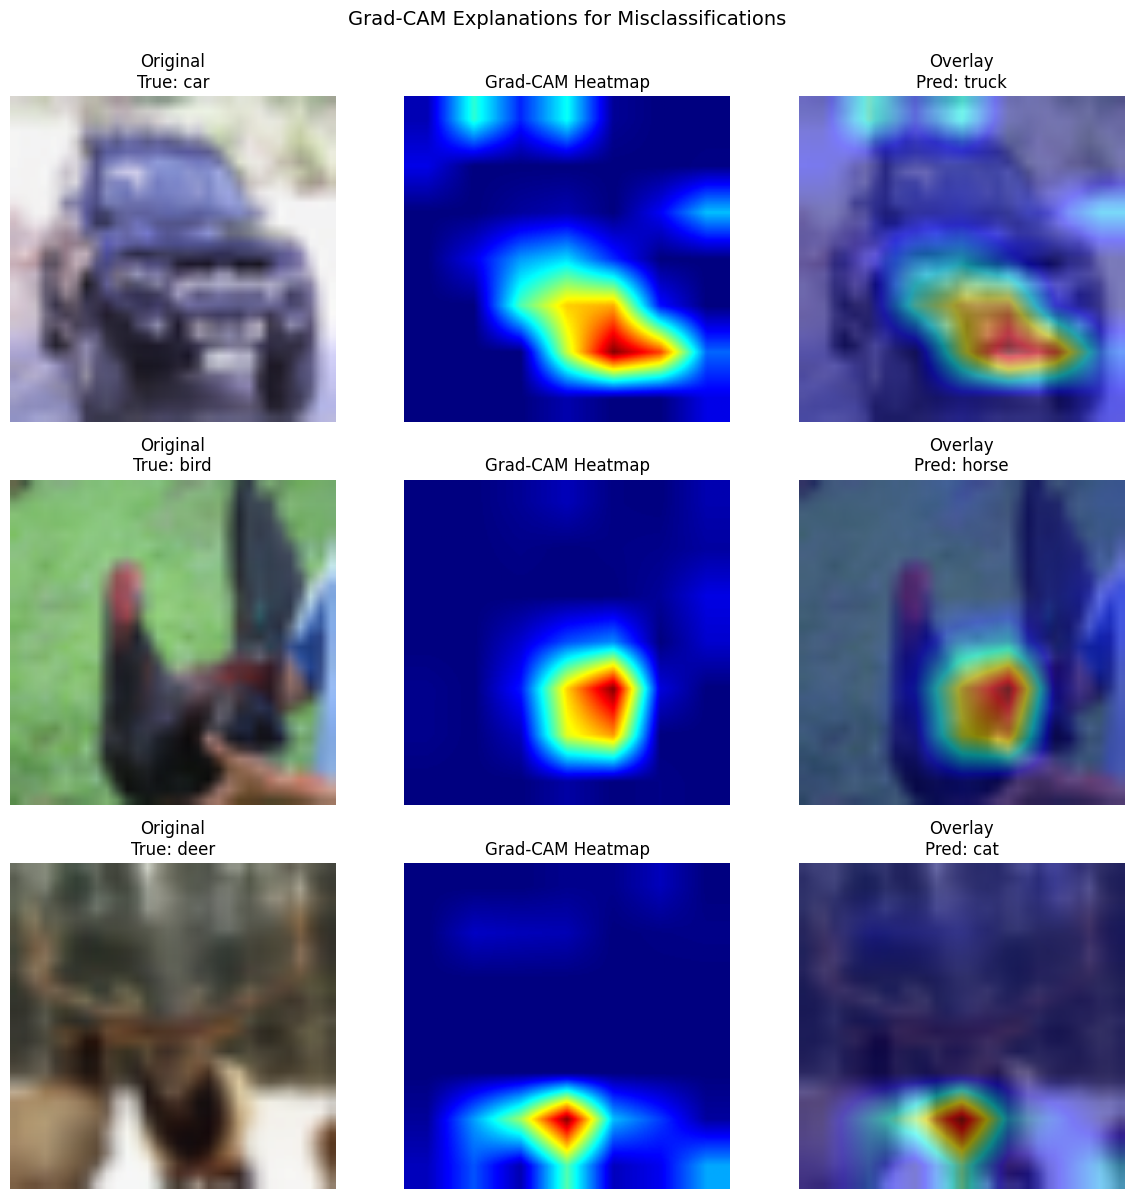

✓ Failure case analysis saved

Failure Case Analysis:
------------------------------------------------------------
Why the model failed:
  • Model may focus on background instead of main object
  • Confusing visual similarities (e.g., cat vs dog)
  • Ambiguous or occluded objects in image
  • Insufficient discriminative features in focused region
  • Training data bias or insufficient examples

Grad-CAM reveals:
  • Where the model looked when making wrong prediction
  • Whether it focused on irrelevant regions
  • Helps identify systematic errors in model behavior
------------------------------------------------------------



'\n\n1. **Why Explainability Matters:**\n   - Builds trust in model decisions\n   - Identifies failure modes and biases\n   - Guides model improvement\n   - Required for high-stakes applications (medical, autonomous vehicles)\n\n2. **Filter Visualization Findings:**\n   - First layer: simple edge/color detectors\n   - Deeper layers: abstract, hierarchical features\n   - Complexity increases with depth\n\n3. **Feature Map Insights:**\n   - Different channels specialize in different patterns\n   - Sparse activation patterns\n   - Shows what model "sees" at each layer\n\n4. **Grad-CAM Effectiveness:**\n   - Highlights important image regions\n   - Validates model reasoning\n   - Exposes failure modes\n   - Aligns with human intuition for correct predictions\n\n5. **Failure Analysis:**\n   - Reveals when model focuses on wrong regions\n   - Identifies confusing visual similarities\n   - Helps improve training data and architecture\n'

In [2]:

# ============================================================
# PROBLEM 1: Vision Model Setup
# ============================================================

print("="*60)
print("PROBLEM 1: Vision Model Setup")
print("="*60)

# 1.1 Load CIFAR-10 Dataset
# --------------------------
print("\n📥 Loading CIFAR-10 dataset...")

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(224),  # ResNet expects 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

print(f"✓ Dataset loaded")
print(f"Training samples: {len(trainset)}")
print(f"Test samples: {len(testset)}")
print(f"Classes: {classes}\n")

# 1.2 Load Pretrained ResNet-50
# ------------------------------
print("🤖 Loading pretrained ResNet-50...")

model = models.resnet50(weights='DEFAULT')

# Replace final layer for CIFAR-10 (10 classes)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 10)

model = model.to(device)

print(f" Model loaded: ResNet-50")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}\n")

# Print model architecture summary
print("Model Architecture Summary:")
print("-" * 60)
for name, module in model.named_children():
    print(f"{name:20s} -> {str(module.__class__.__name__):30s}")
print("-" * 60)

# 1.3 Train the Model (or load pretrained)
# -----------------------------------------
print("\n Training model (fine-tuning final layer)...")

# Freeze all layers except final classifier
for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)

# Quick training (3 epochs for demo - increase for better accuracy)
num_epochs = 3

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(trainloader, desc=f'Epoch {epoch+1}/{num_epochs}')
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        pbar.set_postfix({'loss': running_loss/len(pbar), 'acc': 100.*correct/total})

print("Training complete\n")

# 1.4 Evaluate Model
# ------------------
print(" Evaluating on test set...")

model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []
all_images = []

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_images.extend(images.cpu())

accuracy = 100. * correct / total
print(f"Test Accuracy: {accuracy:.2f}%\n")

# Show sample predictions
print("Sample Predictions:")
print("-" * 60)
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i in range(10):
    ax = axes[i//5, i%5]
    img = all_images[i].permute(1, 2, 0).numpy()
    # Denormalize
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)

    ax.imshow(img)
    ax.set_title(f"True: {classes[all_labels[i]]}\nPred: {classes[all_preds[i]]}")
    ax.axis('off')

plt.tight_layout()
plt.savefig('xai_outputs/problem1_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Sample predictions saved to xai_outputs/problem1_predictions.png\n")

# ============================================================
# PROBLEM 2: Visualizing Learned Filters
# ============================================================

print("="*60)
print("PROBLEM 2: Visualizing Learned Filters")
print("="*60)

def visualize_filters(model, layer_name, num_filters=64):
    """Visualize convolutional filters"""
    # Get the layer
    layer = dict(model.named_modules())[layer_name]

    # Get filter weights
    filters = layer.weight.data.cpu()

    # Normalize filters to [0, 1]
    filters = (filters - filters.min()) / (filters.max() - filters.min())

    # Plot filters
    n_filters = min(num_filters, filters.shape[0])
    n_cols = 8
    n_rows = (n_filters + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows*2))
    axes = axes.flatten()

    for i in range(n_filters):
        filter_img = filters[i]

        # If 3 channels (RGB), show as color
        if filter_img.shape[0] == 3:
            filter_img = filter_img.permute(1, 2, 0).numpy()
        else:
            # Take first channel for deeper layers
            filter_img = filter_img[0].numpy()

        axes[i].imshow(filter_img, cmap='viridis')
        axes[i].axis('off')
        axes[i].set_title(f'F{i}', fontsize=8)

    # Hide unused subplots
    for i in range(n_filters, len(axes)):
        axes[i].axis('off')

    return fig

# 2.1 First Convolutional Layer Filters
# --------------------------------------
print("\n Visualizing first layer filters (conv1)...")

fig1 = visualize_filters(model, 'conv1', num_filters=64)
fig1.suptitle('First Layer Filters (conv1) - Low-level Features', fontsize=14, y=1.00)
plt.tight_layout()
plt.savefig('xai_outputs/problem2_first_layer_filters.png', dpi=300, bbox_inches='tight')
plt.show()

print(" First layer filters saved")

# 2.2 Deeper Layer Filters
# -------------------------
print("\n Visualizing deeper layer filters (layer2.0.conv1)...")

fig2 = visualize_filters(model, 'layer2.0.conv1', num_filters=64)
fig2.suptitle('Deeper Layer Filters (layer2.0.conv1) - Higher-level Features', fontsize=14, y=1.00)
plt.tight_layout()
plt.savefig('xai_outputs/problem2_deeper_layer_filters.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Deeper layer filters saved\n")

print("Analysis:")
print("-" * 60)
print("First Layer Filters:")
print("  • Capture low-level patterns: edges, corners, color gradients")
print("  • Simple, interpretable patterns (horizontal/vertical edges)")
print("  • Act as basic feature detectors")
print("\nDeeper Layer Filters:")
print("  • More complex, abstract patterns")
print("  • Harder to interpret visually")
print("  • Detect combinations of low-level features")
print("  • Represent higher-level semantic concepts")
print("-" * 60 + "\n")

# ============================================================
# PROBLEM 3: Feature Map Visualization
# ============================================================

print("="*60)
print("PROBLEM 3: Feature Map Visualization")
print("="*60)

def get_feature_maps(model, layer_name, input_image):
    """Extract feature maps from a specific layer"""
    activation = {}

    def hook_fn(module, input, output):
        activation['features'] = output.detach()

    # Register hook
    layer = dict(model.named_modules())[layer_name]
    hook = layer.register_forward_hook(hook_fn)

    # Forward pass
    model.eval()
    with torch.no_grad():
        _ = model(input_image.unsqueeze(0).to(device))

    # Remove hook
    hook.remove()

    return activation['features'].cpu()

def visualize_feature_maps(original_img, feature_maps, num_maps=16):
    """Visualize feature maps"""
    feature_maps = feature_maps.squeeze(0)  # Remove batch dimension

    # Select subset of feature maps
    n_maps = min(num_maps, feature_maps.shape[0])
    n_cols = 4
    n_rows = (n_maps + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows + 1, n_cols, figsize=(12, (n_rows + 1) * 3))

    # Show original image in first row
    for i in range(n_cols):
        if i == 0:
            axes[0, i].imshow(original_img)
            axes[0, i].set_title('Original Image', fontsize=10)
        axes[0, i].axis('off')

    # Show feature maps
    for i in range(n_maps):
        row = (i // n_cols) + 1
        col = i % n_cols

        fmap = feature_maps[i].numpy()
        axes[row, col].imshow(fmap, cmap='viridis')
        axes[row, col].set_title(f'Channel {i}', fontsize=8)
        axes[row, col].axis('off')

    # Hide unused subplots
    for i in range(n_maps, n_rows * n_cols):
        row = (i // n_cols) + 1
        col = i % n_cols
        if row < axes.shape[0]:
            axes[row, col].axis('off')

    return fig

# Select a test image
print("\n Selecting test image for feature map visualization...")
test_img_idx = 0
test_img = all_images[test_img_idx]
test_label = all_labels[test_img_idx]

# Denormalize for display
img_display = test_img.permute(1, 2, 0).numpy()
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
img_display = std * img_display + mean
img_display = np.clip(img_display, 0, 1)

# Get feature maps from intermediate layer
print(f"Extracting feature maps from layer3.0.conv1...")
feature_maps = get_feature_maps(model, 'layer3.0.conv1', test_img)

print(f"Feature map shape: {feature_maps.shape}")

# Visualize
fig3 = visualize_feature_maps(img_display, feature_maps, num_maps=16)
fig3.suptitle(f'Feature Maps - Layer3.0.conv1 (True: {classes[test_label]})',
              fontsize=14, y=0.995)
plt.tight_layout()
plt.savefig('xai_outputs/problem3_feature_maps.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Feature maps saved\n")

print("Discussion:")
print("-" * 60)
print("Feature Map Observations:")
print("  • Different channels activate for different image regions")
print("  • Some channels focus on edges and boundaries")
print("  • Others respond to textures and patterns")
print("  • Activations are sparse - most channels show selective responses")
print("  • Higher activation (brighter) = stronger feature presence")
print("-" * 60 + "\n")

# ============================================================
# PROBLEM 4: Grad-CAM for Model Explainability
# ============================================================

print("="*60)
print("PROBLEM 4: Grad-CAM Implementation")
print("="*60)

class GradCAM:
    """Gradient-weighted Class Activation Mapping"""

    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Register hooks
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()

        target = dict(self.model.named_modules())[self.target_layer]
        target.register_forward_hook(forward_hook)
        target.register_full_backward_hook(backward_hook)

    def generate_cam(self, input_image, target_class=None):
        """Generate Grad-CAM heatmap"""
        self.model.eval()

        # Forward pass
        input_image = input_image.unsqueeze(0).to(device)
        input_image.requires_grad = True

        output = self.model(input_image)

        # If no target class, use predicted class
        if target_class is None:
            target_class = output.argmax(dim=1).item()

        # Backward pass
        self.model.zero_grad()
        class_score = output[0, target_class]
        class_score.backward()

        # Calculate weights
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)

        # Weighted combination of activation maps
        cam = (weights * self.activations).sum(dim=1, keepdim=True)
        cam = F.relu(cam)  # ReLU to focus on positive influence

        # Normalize
        cam = cam.squeeze().cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

        return cam, target_class

def apply_colormap_on_image(image, cam, alpha=0.5):
    """Overlay CAM heatmap on image"""
    # Resize CAM to image size
    h, w = image.shape[:2]
    cam_resized = cv2.resize(cam, (w, h))

    # Apply colormap
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    heatmap = heatmap / 255.0

    # Overlay
    overlayed = (1 - alpha) * image + alpha * heatmap
    overlayed = np.clip(overlayed, 0, 1)

    return overlayed, heatmap

# Initialize Grad-CAM
print("\n Initializing Grad-CAM (target layer: layer4)...")
gradcam = GradCAM(model, 'layer4')

# Select correctly classified images
print("Finding correctly classified images...")
correct_indices = [i for i in range(len(all_preds))
                   if all_preds[i] == all_labels[i]][:3]

# Generate Grad-CAM visualizations
fig4, axes = plt.subplots(3, 3, figsize=(12, 12))

for idx, img_idx in enumerate(correct_indices):
    # Get image
    img_tensor = all_images[img_idx]
    true_label = all_labels[img_idx]
    pred_label = all_preds[img_idx]

    # Denormalize
    img_display = img_tensor.permute(1, 2, 0).numpy()
    img_display = std * img_display + mean
    img_display = np.clip(img_display, 0, 1)

    # Generate CAM
    cam, predicted_class = gradcam.generate_cam(img_tensor, target_class=pred_label)

    # Apply colormap
    overlayed, heatmap = apply_colormap_on_image(img_display, cam)

    # Plot
    axes[idx, 0].imshow(img_display)
    axes[idx, 0].set_title(f'Original\n{classes[true_label]}')
    axes[idx, 0].axis('off')

    axes[idx, 1].imshow(heatmap)
    axes[idx, 1].set_title('Grad-CAM Heatmap')
    axes[idx, 1].axis('off')

    axes[idx, 2].imshow(overlayed)
    axes[idx, 2].set_title('Overlay')
    axes[idx, 2].axis('off')

plt.suptitle('Grad-CAM Explanations for Correct Predictions', fontsize=14, y=0.995)
plt.tight_layout()
plt.savefig('xai_outputs/problem4_gradcam_correct.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Grad-CAM visualizations saved\n")

print("Interpretation:")
print("-" * 60)
print("Grad-CAM Analysis (Correctly Classified):")
print("  • Heatmaps highlight discriminative regions")
print("  • Model focuses on object-specific features")
print("  • Bright regions = high importance for prediction")
print("  • Alignswith human intuition (focuses on main object)")
print("-" * 60 + "\n")

# ============================================================
# PROBLEM 5: Failure Case Analysis
# ============================================================

print("="*60)
print("PROBLEM 5: Failure Case Analysis")
print("="*60)

# Find misclassified images
print("\n Finding misclassified images...")
incorrect_indices = [i for i in range(len(all_preds))
                     if all_preds[i] != all_labels[i]][:3]

if len(incorrect_indices) == 0:
    print(" No misclassifications found! Model is perfect on test set.")
    incorrect_indices = correct_indices[:3]  # Use correct ones for demo

fig5, axes = plt.subplots(len(incorrect_indices), 3, figsize=(12, len(incorrect_indices)*4))
if len(incorrect_indices) == 1:
    axes = axes.reshape(1, -1)

for idx, img_idx in enumerate(incorrect_indices):
    # Get image
    img_tensor = all_images[img_idx]
    true_label = all_labels[img_idx]
    pred_label = all_preds[img_idx]

    # Denormalize
    img_display = img_tensor.permute(1, 2, 0).numpy()
    img_display = std * img_display + mean
    img_display = np.clip(img_display, 0, 1)

    # Generate CAM
    cam, predicted_class = gradcam.generate_cam(img_tensor, target_class=pred_label)

    # Apply colormap
    overlayed, heatmap = apply_colormap_on_image(img_display, cam)

    # Plot
    axes[idx, 0].imshow(img_display)
    axes[idx, 0].set_title(f'Original\nTrue: {classes[true_label]}')
    axes[idx, 0].axis('off')

    axes[idx, 1].imshow(heatmap)
    axes[idx, 1].set_title('Grad-CAM Heatmap')
    axes[idx, 1].axis('off')

    axes[idx, 2].imshow(overlayed)
    axes[idx, 2].set_title(f'Overlay\nPred: {classes[pred_label]}')
    axes[idx, 2].axis('off')

plt.suptitle('Grad-CAM Explanations for Misclassifications', fontsize=14, y=0.995)
plt.tight_layout()
plt.savefig('xai_outputs/problem5_failure_cases.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Failure case analysis saved\n")

print("Failure Case Analysis:")
print("-" * 60)
print("Why the model failed:")
print("  • Model may focus on background instead of main object")
print("  • Confusing visual similarities (e.g., cat vs dog)")
print("  • Ambiguous or occluded objects in image")
print("  • Insufficient discriminative features in focused region")
print("  • Training data bias or insufficient examples")
print("\nGrad-CAM reveals:")
print("  • Where the model looked when making wrong prediction")
print("  • Whether it focused on irrelevant regions")
print("  • Helps identify systematic errors in model behavior")
print("-" * 60 + "\n")



"""

1. **Why Explainability Matters:**
   - Builds trust in model decisions
   - Identifies failure modes and biases
   - Guides model improvement
   - Required for high-stakes applications (medical, autonomous vehicles)

2. **Filter Visualization Findings:**
   - First layer: simple edge/color detectors
   - Deeper layers: abstract, hierarchical features
   - Complexity increases with depth

3. **Feature Map Insights:**
   - Different channels specialize in different patterns
   - Sparse activation patterns
   - Shows what model "sees" at each layer

4. **Grad-CAM Effectiveness:**
   - Highlights important image regions
   - Validates model reasoning
   - Exposes failure modes
   - Aligns with human intuition for correct predictions

5. **Failure Analysis:**
   - Reveals when model focuses on wrong regions
   - Identifies confusing visual similarities
   - Helps improve training data and architecture
"""